In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#############################
# Read file
#############################

file = 'networkScores'
outputFile = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/without2DPFPs/' + file + '.npz'

print('Reading file: ', str(outputFile),', This may take a while...')

data = np.load(outputFile)

particle_mask_in = data['particle_mask']
trueTrackID_in = data['trueTrackID']
trueVisibleGeneration_in = data['trueVisibleGeneration']
trueVisibleParentTrackID_in = data['trueVisibleParentTrackID']
particleIndex_in = data['particleIndex']
primaryScores_in = data['primaryScores']
link_mask_in = data['link_mask']
higherTierChildIndex_in = data['higherTierChildIndex']
higherTierParentIndex_in = data['higherTierParentIndex']
higherTierScores_in = data['higherTierScores']

nEntries = len(trueVisibleGeneration_in)

print('nEntries:', nEntries)

Reading file:  /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/without2DPFPs/networkScores.npz , This may take a while...
nEntries: 1


In [ ]:
############################
# Tune primaries
############################

# NEED TO ACTUALLY GET RID OF THOSE THAT DONT HAVE ANY TRUTH! AGHHHHHHH



In [3]:
############################
# Tune primaries
############################

primary_thresholds = []
primary_efficiency = []
primary_purity = []
primary_metric = []

primaries_as_primaries_frac = []
primaries_as_other_frac = []
other_as_primaries_frac = []
other_as_other_frac = []

############################
# Loop through thresholds
############################
for primary_threshold in range(0, 11) :
    
    primary_threshold /= float(10)
    
    primary_thresholds.append(primary_threshold)
    
    n_true_primaries = 0
    n_primaries_as_primaries = 0
    n_primaries_as_other = 0

    n_true_other = 0
    n_other_as_primaries = 0
    n_other_as_other = 0

    ############################
    # Loop through events
    ############################
    for iEvent in range(nEntries) :

        particle_mask = np.array(particle_mask_in[iEvent])
        particleIndex = np.array(particleIndex_in[iEvent])[particle_mask]
        trueVisibleGeneration = np.array(trueVisibleGeneration_in[iEvent])[particle_mask]
        primaryScores = np.array(primaryScores_in[iEvent])[particle_mask]
        
        nParticles = len(particleIndex)
        
        for iParticle in range(nParticles) :

            if (trueVisibleGeneration[iParticle] == 2) :

                n_true_primaries += 1

                if (primaryScores[iParticle] > primary_threshold) :
                    n_primaries_as_primaries += 1
                else :
                    n_primaries_as_other += 1
            else :

                n_true_other += 1

                if (primaryScores[iParticle] > primary_threshold) :
                    n_other_as_primaries += 1
                else :
                    n_other_as_other += 1
                    
                    
    ############################
    # Work out metrics
    ############################
    selected_primaries = n_primaries_as_primaries + n_other_as_primaries
    primary_efficiency.append(0 if n_true_primaries == 0 else float(n_primaries_as_primaries)/float(n_true_primaries))
    primary_purity.append(0 if selected_primaries == 0 else float(n_primaries_as_primaries)/float(selected_primaries))
    primary_metric.append(primary_efficiency[-1] * primary_purity[-1])
    
    primaries_as_primaries_frac.append(float(n_primaries_as_primaries) / float(n_true_primaries))
    primaries_as_other_frac.append(float(n_primaries_as_other) / float(n_true_primaries))
    other_as_primaries_frac.append(float(n_other_as_primaries) / float(n_true_other))
    other_as_other_frac.append(float(n_other_as_other) / float(n_true_other))

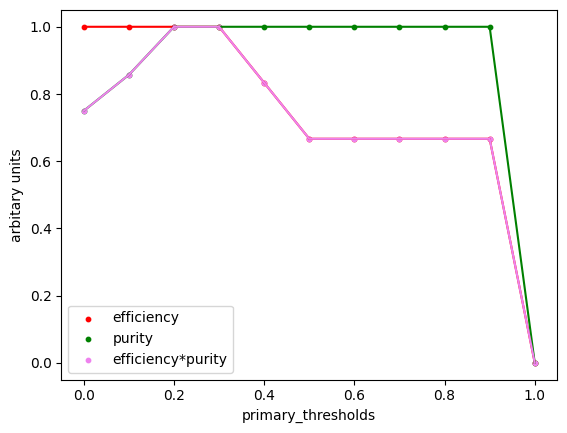

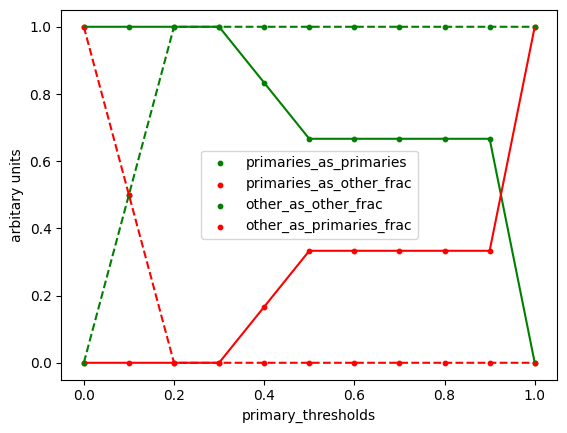

In [4]:
############################
# Primary plot!
############################

plt.clf()
plt.scatter(primary_thresholds, primary_efficiency, color='red', label='efficiency', s=10)
plt.plot(primary_thresholds, primary_efficiency, color='red')
plt.scatter(primary_thresholds, primary_purity, color='green', label='purity', s=10)
plt.plot(primary_thresholds, primary_purity, color='green')
plt.scatter(primary_thresholds, primary_metric, color='violet', label='efficiency*purity', s=10)
plt.plot(primary_thresholds, primary_metric, color='violet')
    
plt.xlabel('primary_thresholds')
plt.ylabel('arbitary units')
plt.legend()
plt.show()

############################

plt.clf()
plt.scatter(primary_thresholds, primaries_as_primaries_frac, color='green', label='primaries_as_primaries', s=10)
plt.plot(primary_thresholds, primaries_as_primaries_frac, color='green')
plt.scatter(primary_thresholds, primaries_as_other_frac, color='red', label='primaries_as_other_frac', s=10)
plt.plot(primary_thresholds, primaries_as_other_frac, color='red')
plt.scatter(primary_thresholds, other_as_other_frac, color='green', label='other_as_other_frac', s=10)
plt.plot(primary_thresholds, other_as_other_frac, color='green', linestyle='dashed')
plt.scatter(primary_thresholds, other_as_primaries_frac, color='red', label='other_as_primaries_frac', s=10)
plt.plot(primary_thresholds, other_as_primaries_frac, color='red', linestyle='dashed')

plt.xlabel('primary_thresholds')
plt.ylabel('arbitary units')
plt.legend()
plt.show()

In [5]:
#######################################
# Define optimal primary threshold
#######################################

PRIMARY_THRESHOLD = 0.5

In [6]:
##################################################
# Build the primary tier with optimised threshold!
##################################################

new_gen = []
new_parentTrackID = []

primaries = []

for iEvent in range(nEntries) :

    particle_mask = np.array(particle_mask_in[iEvent])
    particleIndex = np.array(particleIndex_in[iEvent])[particle_mask]
    primaryScores = np.array(primaryScores_in[iEvent])[particle_mask]
    nParticles = len(particleIndex)
    
    this_parentTrackID = [-1] * nParticles
    this_gen = [-1] * nParticles
    
    this_primaries = []
    
    for iParticle in range(nParticles) :
        
        if (primaryScores[iParticle] > PRIMARY_THRESHOLD) :
            this_primaries.append(iParticle)
            this_gen[iParticle] = 2
            this_parentTrackID[iParticle] = 0
    
    new_gen.append(this_gen)
    new_parentTrackID.append(this_parentTrackID)
    primaries.append(this_primaries)

In [7]:
############################
# Tune higher tiers
############################

higher_thresholds = []

secondary_correct_parent_frac = []
secondary_no_parent_frac = []
secondary_incorrect_parent_frac = []

higher_correct_parent_frac = []
higher_no_parent_frac = []
higher_incorrect_parent_frac = []

############################
# Loop through thresholds
############################
for higher_threshold in range(0, 11) :
    
    higher_threshold /= float(10)
    
    higher_thresholds.append(higher_threshold)

    n_secondary = 0
    secondary_correct_parent = 0
    secondary_no_parent = 0
    secondary_incorrect_parent = 0

    n_higher = 0
    higher_correct_parent = 0
    higher_no_parent = 0
    higher_incorrect_parent = 0

    ############################
    # Loop through events
    ############################

    for iEvent in range(nEntries) :

        this_particle_tiers = [[]]
        this_particle_tiers[0] = primaries[iEvent]

        this_parentTrackID = new_parentTrackID[iEvent].copy()
        this_gen = new_gen[iEvent].copy()
        
        particle_mask = np.array(particle_mask_in[iEvent])       
        trueTrackID = np.array(trueTrackID_in[iEvent])[particle_mask]
        trueVisibleGeneration = np.array(trueVisibleGeneration_in[iEvent])[particle_mask]
        trueVisibleParentTrackID = np.array(trueVisibleParentTrackID_in[iEvent])[particle_mask]
        particleIndex = np.array(particleIndex_in[iEvent])[particle_mask]
        
        link_mask = np.array(link_mask_in[iEvent])
        higherTierChildIndex = np.array(higherTierChildIndex_in[iEvent])[link_mask]
        higherTierParentIndex = np.array(higherTierParentIndex_in[iEvent])[link_mask]
        higherTierScores = np.array(higherTierScores_in[iEvent])[link_mask]

        ############################
        # Build hierarchy
        ############################    

        # Fill each tier at a time
        while (len(this_particle_tiers[-1]) != 0) :

            tier = []

            # Have to find the highest link out of all possible links - to ensure best links are made        
            found = True

            while (found) :
        
                iFoundParent = -1
                iFoundChild = -1
                highestLinkScore = -1
                found = False

                # Loop over particles in last built tier
                for iParent in this_particle_tiers[-1]:

                    this_parentIndex = particleIndex[iParent]

                    # Loop over its links
                    for iLink in (np.where(higherTierParentIndex == this_parentIndex)[0]) : 

                        this_childIndex = higherTierChildIndex[iLink]
                        iChild = np.where(particleIndex == this_childIndex)[0][0]

                        # If the child has already been assigned a parent
                        if (this_gen[iChild] != -1) :
                            continue

                        this_higherTierScore = higherTierScores[iLink]
                        
                        if ((this_higherTierScore > highestLinkScore) and (this_higherTierScore > higher_threshold)) :

                            highestLinkScore = this_higherTierScore
                            iFoundParent = iParent
                            iFoundChild = iChild
                            found = True
                            
                # If link found, add into this tier
                if (found) :
                    this_parentTrackID[iFoundChild] = trueTrackID[iFoundParent]
                    this_gen[iFoundChild] = len(this_particle_tiers) + 2
                    tier.append(iFoundChild)

            # Tier complete, add into hierarchy
            this_particle_tiers.append(tier)
    
        ############################
        # Add counts for event
        ############################    
        this_parentTrackID = np.array(this_parentTrackID)
        this_gen = np.array(this_gen)

        true_secondary_mask = (trueVisibleGeneration == 3)
        n_secondary += np.count_nonzero(true_secondary_mask)
        secondary_correct_parent += np.count_nonzero(trueVisibleParentTrackID[true_secondary_mask] == this_parentTrackID[true_secondary_mask])
        secondary_no_parent += np.count_nonzero(this_gen[true_secondary_mask] == -1)
        secondary_incorrect_parent += np.count_nonzero(np.logical_and(this_gen[true_secondary_mask] != -1, \
                                                                      trueVisibleParentTrackID[true_secondary_mask] != this_parentTrackID[true_secondary_mask]))
        true_higher_mask = trueVisibleGeneration > 3
        n_higher += np.count_nonzero(true_higher_mask)
        higher_correct_parent += np.count_nonzero(trueVisibleParentTrackID[true_higher_mask] == this_parentTrackID[true_higher_mask])
        higher_no_parent += np.count_nonzero(this_gen[true_higher_mask] == -1)
        higher_incorrect_parent += np.count_nonzero(np.logical_and(this_gen[true_higher_mask] != -1, \
                                                                   trueVisibleParentTrackID[true_higher_mask] != this_parentTrackID[true_higher_mask]))
        
    ############################
    # Calculate metrics for threshold
    ############################      
    secondary_correct_parent_frac.append(0 if n_secondary == 0 else float(secondary_correct_parent)/float(n_secondary))
    secondary_no_parent_frac.append(0 if n_secondary == 0 else float(secondary_no_parent)/float(n_secondary))
    secondary_incorrect_parent_frac.append(0 if n_secondary == 0 else float(secondary_incorrect_parent)/float(n_secondary))
    higher_correct_parent_frac.append(0 if n_higher == 0 else float(higher_correct_parent)/float(n_higher))
    higher_no_parent_frac.append(0 if n_higher == 0 else float(higher_no_parent)/float(n_higher))
    higher_incorrect_parent_frac.append(0 if n_higher == 0 else float(higher_incorrect_parent)/float(n_higher))

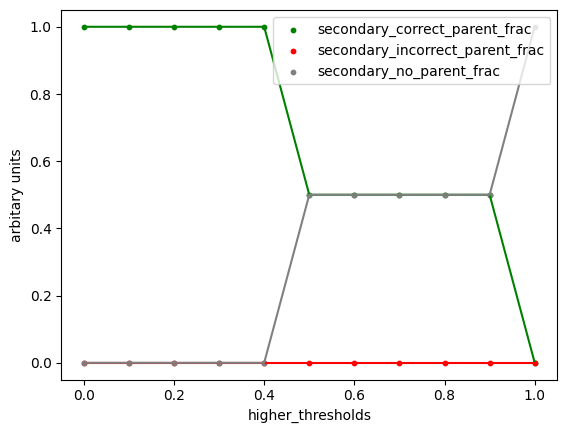

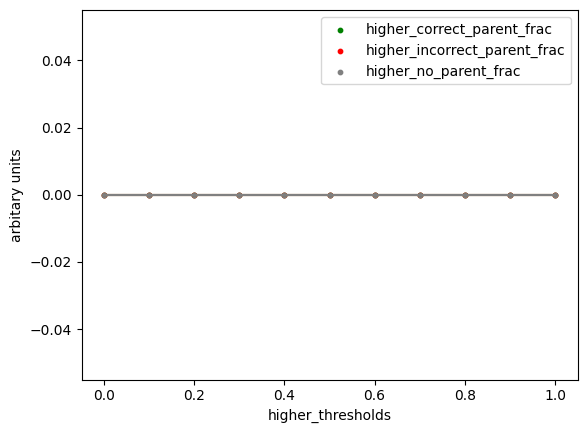

In [8]:
############################
# Higher tier plot!
############################

plt.clf()
plt.scatter(higher_thresholds, secondary_correct_parent_frac, color='green', label='secondary_correct_parent_frac', s=10)
plt.plot(higher_thresholds, secondary_correct_parent_frac, color='green')

plt.scatter(higher_thresholds, secondary_incorrect_parent_frac, color='red', label='secondary_incorrect_parent_frac', s=10)
plt.plot(higher_thresholds, secondary_incorrect_parent_frac, color='red')

plt.scatter(higher_thresholds, secondary_no_parent_frac, color='gray', label='secondary_no_parent_frac', s=10)
plt.plot(higher_thresholds, secondary_no_parent_frac, color='gray')
    
plt.xlabel('higher_thresholds')
plt.ylabel('arbitary units')
plt.legend()
plt.show()

############################

plt.clf()
plt.scatter(higher_thresholds, higher_correct_parent_frac, color='green', label='higher_correct_parent_frac', s=10)
plt.plot(higher_thresholds, higher_correct_parent_frac, color='green')

plt.scatter(higher_thresholds, higher_incorrect_parent_frac, color='red', label='higher_incorrect_parent_frac', s=10)
plt.plot(higher_thresholds, higher_incorrect_parent_frac, color='red')

plt.scatter(higher_thresholds, higher_no_parent_frac, color='gray', label='higher_no_parent_frac', s=10)
plt.plot(higher_thresholds, higher_no_parent_frac, color='gray')
    
plt.xlabel('higher_thresholds')
plt.ylabel('arbitary units')
plt.legend()
plt.show()